In [1]:
import pandas as pd
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
## We will download the "Fire Incidents Data" csv file from Toronto website using this URL
## https://open.toronto.ca/dataset/fire-incidents/

from urllib.parse import unquote

# URL of the CSV file
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/64a26694-01dc-4ec3-aa87-ad8509604f50/resource/1e824947-d73b-4f48-9bac-7f7f3731a6b9/download/Fire%20Incidents%20Data.csv"

# Get the file name from the URL and decode URL-encoded characters
file_name = unquote(url.split("/")[-1])

# Download the file
response = requests.get(url)
with open(file_name, 'wb') as file:
    file.write(response.content)

print(f"File '{file_name}' downloaded to the current working directory.")

File 'Fire Incidents Data.csv' downloaded to the current working directory.


In [3]:
## To fix this error: typeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
## Will change the dtype for column 18 Incident_Number --> string instead of object
column_types = {'Incident_Number': str} 

# Read the CSV file into a DataFrame
fires = pd.read_csv(file_name, dtype=column_types, low_memory=False)
fires.head()

,_id,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,...,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,TFS_Firefighter_Casualties
0,2092816,81 - Engine Area,NaN,NaN,0.0,0.0,15000.0,NaN,NaN,2018-02-24T21:12:00,...,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",2018-02-24T21:04:29,2018-02-24T21:10:11,0.0
1,2092817,"75 - Trash, rubbish area (outside)",NaN,NaN,0.0,0.0,50.0,NaN,NaN,2018-02-24T21:29:42,...,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-24T21:24:43,2018-02-24T21:29:31,0.0
2,2092818,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T13:29:59,2018-02-25T13:36:49,0.0
3,2092819,"75 - Trash, rubbish area (outside)",01 - Normal (no change),1 - No business interruption,0.0,0.0,0.0,0.0,NaN,2018-02-25T14:19:25,...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",99 - Undetermined,8 - Not applicable - no sprinkler system present,9 - Undetermined,3 - Fire with smoke showing only - including v...,2018-02-25T14:13:39,2018-02-25T14:18:07,0.0
4,2092820,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-25T18:20:43,2018-02-25T18:26:19,0.0


In [4]:
### convert alarm_time and arrival_time to timedelta fields and then 
### calculate difference between alarm time and arrival time and place in new column called response_time

fires['TFS_Alarm_Time'] =pd.to_datetime(fires['TFS_Alarm_Time'],errors='coerce')
fires['TFS_Arrival_Time'] = pd.to_datetime(fires['TFS_Arrival_Time'],errors='coerce')
fires['response_time'] = fires['TFS_Arrival_Time'] - fires['TFS_Alarm_Time']
fires['response_time'] = pd.to_timedelta(fires['response_time'])


## Remove all rows with Incident_Ward = 0, as we didn't find Ward=0 in Toronto Ward List below
## https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/ward-profiles/44-ward-model/
fires = fires[fires["Incident_Ward"] != 0]

# condense df down to only the columns and dates we are working with (2011-2017)
cols_to_keep = ['Incident_Ward','TFS_Alarm_Time','TFS_Arrival_Time', 'response_time']
fires_reduced = fires[cols_to_keep]
fires_reduced = fires_reduced.sort_values('TFS_Arrival_Time', ascending=True)
fires_reduced = fires_reduced.loc[(fires_reduced['TFS_Arrival_Time'] >= '2011-01-01') & 
                                  (fires_reduced['TFS_Arrival_Time'] <= '2018-01-01')]
fires_reduced.tail()


,Incident_Ward,TFS_Alarm_Time,TFS_Arrival_Time,response_time
18509,5.0,2017-12-31 19:38:59,2017-12-31 19:43:58,0 days 00:04:59
7932,11.0,2017-12-31 20:22:33,2017-12-31 20:30:20,0 days 00:07:47
9658,2.0,2017-12-31 22:55:53,2017-12-31 23:02:37,0 days 00:06:44
14667,1.0,2017-12-31 23:14:33,2017-12-31 23:19:18,0 days 00:04:45
18510,31.0,2017-12-31 23:21:07,2017-12-31 23:24:59,0 days 00:03:52


In [5]:
# Sort by ward column in ascending order and drop rows with missing values

fires_reduced = fires_reduced.dropna(axis=0)
fires_reduced = fires_reduced.sort_values('Incident_Ward', axis=0, ascending=True)
fires_reduced.head()

,Incident_Ward,TFS_Alarm_Time,TFS_Arrival_Time,response_time
16634,1.0,2017-02-21 05:33:26,2017-02-21 05:40:25,0 days 00:06:59
12129,1.0,2016-05-07 14:07:08,2016-05-07 14:16:26,0 days 00:09:18
15116,1.0,2014-06-09 18:32:42,2014-06-09 18:37:04,0 days 00:04:22
18183,1.0,2012-10-09 14:14:27,2012-10-09 14:19:40,0 days 00:05:13
9995,1.0,2013-01-15 18:48:55,2013-01-15 18:52:51,0 days 00:03:56


In [6]:
### Create new column to convert the response_time which is in timedelta format to just a regular float to reprsent how many 
### minutes the response took. Not converting to int or float will cause the groupby and mean() line below to fail

fires_reduced.Incident_Ward.astype(float)
fires_reduced['minutes'] = round(fires_reduced['response_time'] / pd.Timedelta(minutes=1),2)
fires_reduced.head()

,Incident_Ward,TFS_Alarm_Time,TFS_Arrival_Time,response_time,minutes
16634,1.0,2017-02-21 05:33:26,2017-02-21 05:40:25,0 days 00:06:59,6.98
12129,1.0,2016-05-07 14:07:08,2016-05-07 14:16:26,0 days 00:09:18,9.30
15116,1.0,2014-06-09 18:32:42,2014-06-09 18:37:04,0 days 00:04:22,4.37
18183,1.0,2012-10-09 14:14:27,2012-10-09 14:19:40,0 days 00:05:13,5.22
9995,1.0,2013-01-15 18:48:55,2013-01-15 18:52:51,0 days 00:03:56,3.93


In [7]:
fires_avg = fires_reduced.groupby('Incident_Ward')['minutes'].mean().reset_index()
fires_avg['minutes'] = round(fires_avg['minutes'],2)
fires_avg = fires_avg.rename(columns={'Incident_Ward': 'Ward', 'minutes': 'Average response time (minutes)'})
fires_avg

,Ward,Average response time (minutes)
0,1.0,5.46
1,2.0,6.15
2,3.0,6.04
3,4.0,5.56
4,5.0,5.56
5,6.0,5.70
6,7.0,5.39
7,8.0,5.63
8,9.0,5.32
9,10.0,5.49


In [13]:
pip install beautifulsoup4

In [12]:
pip install pypdf2

     ---------------------------------------- 0.0/232.6 kB ? eta -:--:--
     ---- -------------------------------- 30.7/232.6 kB 445.2 kB/s eta 0:00:01
     --------- --------------------------- 61.4/232.6 kB 550.5 kB/s eta 0:00:01
     -------------------------------------- 232.6/232.6 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
### RUN THIS CELL ONLY IF YOU WANT DOWNLOAD ALL WARD PROFILE PDFS TO YOUR CURRENT DIRECTORY. 
### This is so that we can later extract text from PDFs to get average income for each ward

import requests
from bs4 import BeautifulSoup as bs
from PyPDF2 import PdfReader

ward_pdfs = np.arange(1,45)
pdfs =[]

for num in ward_pdfs:
    url = f'https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/ward-profiles/44-ward-model/ward-profiles-ward-{num}/'
    page= requests.get(url)
    soup = bs(page.text, 'html.parser')
    container = soup.find_all('a', href=True)   
    link = container[14]['href'] # set url
    pdfs.append(link)
    

# Create sub-directory ward_profiles in our current working directory if not exists
working_dir = os.getcwd()
download_dir = os.path.join(working_dir, 'ward_profiles')
os.makedirs(download_dir, exist_ok=True)

# Download all the PDFs

for count,value in enumerate(pdfs):  
    pdf_resp = requests.get(pdfs[count])
    file_name = pdfs[count].split('_') # split on the underscore and use the last item in the resulting list as the filename so instead of '9904-City_Planning_2016_Census_Profile_2018_Wards_Ward47' we download the pdf as just 'Ward47'
    with open(f'{download_dir}\\{file_name[7]}', 'wb') as f: 
        f.write(pdf_resp.content)
        
print("All pdfs downloaded successfully.")

All pdfs downloaded successfully.


In [10]:
### This cell will extract average housedhold income from all pdfs in specified dir and add them to dataframe
from PyPDF2 import PdfReader
import os

#set this to the dir where ever you downladed the pdfs from cell above
directory = os.chdir(r'C:\Users\corte\Documents\Python_Scripts\Toronto_Fires\ward_profiles') 

pdf_list = [file for file in os.listdir(directory) if file.endswith('.pdf')] # list comprehension: loop through and add all files with extension '.pdf' to list
ward_income = []

for file in pdf_list: # loop through pdfs in list, skipping ward 45, 46, and 47
    reader = PdfReader(file) # load pdf into reader
    page = reader.pages[25] # grab the page we want. I tried using page[4] but the resulting text was very messy and this page seems easier to work with
    text = page.extract_text()
    phrase = text.split('Average household income') # split extracted text on the phrase we want to find
    income = phrase[1].split('$') # split the element in list where the income number is to isolate it
    ward_income.append(int(income[1].replace(',', ''))) # remove the comma, conver to type int and append to ward_income list

fires_avg["Average Ward Income($)"] = ward_income

In [9]:
os.getcwd()

'C:\\Users\\corte\\Documents\\Python_Scripts\\Toronto_Fires'

In [11]:
fires_avg.head()

,Ward,Average response time (minutes),Average Ward Income($)
0,1.0,5.46,70939
1,2.0,6.15,80685
2,3.0,6.04,110440
3,4.0,5.56,141783
4,5.0,5.56,126802


In [23]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [12]:
## We wil download the Ward List from Toronto website using below URL , second tab "Alphabetical listing of wards"
## the table loads in with javascript which can't be handled by beautiful soup so we need to use selenium

from selenium import webdriver 
from selenium.webdriver import Chrome 
from selenium.webdriver.common.by import By 
import time

from io import StringIO 

options = webdriver.ChromeOptions()
options.add_argument('--headless')
driver = Chrome(options=options)
driver.implicitly_wait(5)

url = r'https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/ward-profiles/44-ward-model/#wardListAlpha'
driver.get(url)
# passing a literal string into pd.read_html will show a warning that this is being deprecated. Have to pass it as a 
# file-like object with StringIO
ward_list = pd.read_html(StringIO(driver.page_source))[0] 

driver.close()
print('ward list downloaded')

ward list downloaded


In [14]:
ward_list.head()

,Ward #,Ward Name
0,31,Beaches-East York
1,32,Beaches-East York
2,17,Davenport
3,18,Davenport
4,33,Don Valley East


In [15]:
ward_list = ward_list.sort_values('Ward #', ascending=True)
ward_list.head()

,Ward #,Ward Name
12,1,Etobicoke North
13,2,Etobicoke North
10,3,Etobicoke Centre
11,4,Etobicoke Centre
14,5,Etobicoke-Lakeshore


In [26]:
## Join both DataFrames
# Merge DataFrames
merged_df = pd.merge(fires_avg, ward_list, left_on='Ward', right_on='Ward #')

# Drop the redundant 'Ward' column if needed
merged_df = merged_df.drop('Ward', axis=1)

# Put the order of columns to be friendly
column_order = ['Ward #', 'Ward Name', 'Average response time (minutes)', 'Average Ward Income($)']
merged_df = merged_df[column_order]

# Display the result
merged_df.head()

,Ward #,Ward Name,Average response time (minutes),Average Ward Income($)
0,1,Etobicoke North,5.46,70939
1,2,Etobicoke North,6.15,80685
2,3,Etobicoke Centre,6.04,110440
3,4,Etobicoke Centre,5.56,141783
4,5,Etobicoke-Lakeshore,5.56,126802


In [27]:
# Export the data to csv to keep it
csv_directory = os.path.join(os.pardir,'response_time_income_per_ward.csv')
try:
    merged_df.to_csv(csv_directory, index=False)
    print("response_time_income_per_ward.csv has been exported successfully!")
except PermissionError as e:
    print("Make sure the file isn't open or being used by another program then try running this cell again")

response_time_income_per_ward.csv has been exported successfully!


In [25]:
## Let's try to sort the data by "Average response time (minutes)" ascending and know the minimal response time
merged_df = merged_df.sort_values("Average response time (minutes)", ascending=True)
merged_df.head(10)

,Ward #,Ward Name,Average response time (minutes),Average Ward Income($)
26,27,Toronto Centre-Rosedale,4.18,145614
19,20,Trinity-Spadina,4.43,104119
27,28,Toronto Centre-Rosedale,4.44,90911
17,18,Davenport,4.58,77510
28,29,Toronto-Danforth,4.58,100840
13,14,Parkdale-High Park,4.69,79073
12,13,Parkdale-High Park,4.71,119822
21,22,St. Paul's,4.81,167159
29,30,Toronto-Danforth,4.81,105059
20,21,St. Paul's,4.87,151848


In [23]:
## Let's try to sort the data by "Average Ward Income($)" descending and check the response time
merged_df = merged_df.sort_values("Average Ward Income($)", ascending=False)
merged_df.head(10)

,Ward #,Ward Name,Average response time (minutes),Average Ward Income($)
24,25,Don Valley West,5.60,261595
15,16,Eglinton-Lawrence,4.91,233103
21,22,St. Paul's,4.81,167159
20,21,St. Paul's,4.87,151848
26,27,Toronto Centre-Rosedale,4.18,145614
3,4,Etobicoke Centre,5.56,141783
4,5,Etobicoke-Lakeshore,5.56,126802
31,32,Beaches-East York,8.13,123511
12,13,Parkdale-High Park,4.71,119822
2,3,Etobicoke Centre,6.04,110440


In [28]:
# Read the attached CSV file from the email sent
fire_incidents = pd.read_csv(csv_directory,sep=",")
fire_incidents

,Ward #,Ward Name,Average response time (minutes),Average Ward Income($)
0,1,Etobicoke North,5.46,70939
1,2,Etobicoke North,6.15,80685
2,3,Etobicoke Centre,6.04,110440
3,4,Etobicoke Centre,5.56,141783
4,5,Etobicoke-Lakeshore,5.56,126802
5,6,Etobicoke-Lakeshore,5.70,87794
6,7,York West,5.39,72300
7,8,York West,5.63,59421
8,9,York Centre,5.32,71681
9,10,York Centre,5.49,92587


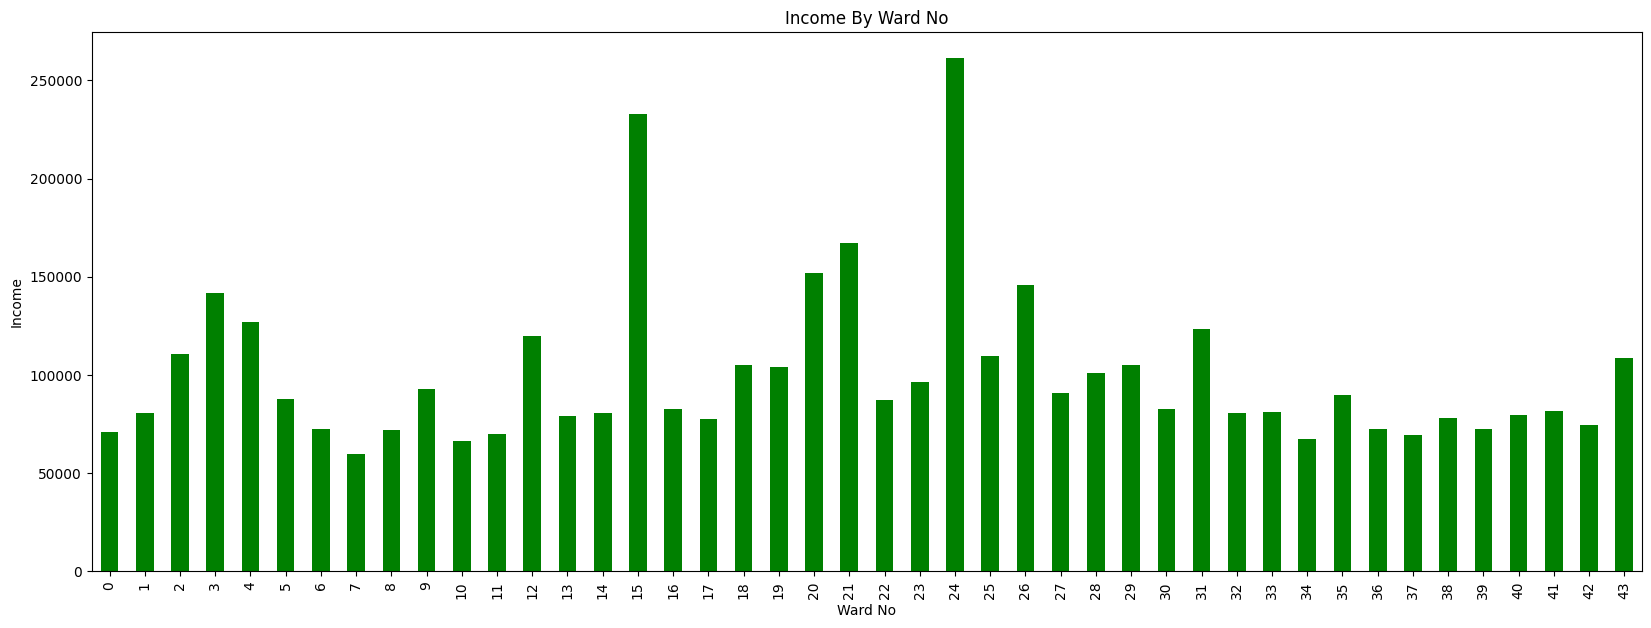

In [29]:
# Assigning Name  Variables to plot different graphs 
fire_incidents_response = fire_incidents['Average response time (minutes)'] # selecting average response time column
fire_incidents_income = fire_incidents['Average Ward Income($)'] # selecting average ward income column
fire_incidents_income_response = fire_incidents[['Average response time (minutes)', 'Average Ward Income($)']] #selecting both response time and income column to plot correlation scatter graph
fire_incidents_income_response
fire_incidents_income.plot.bar(x='Ward No',y='Income',color = ['green'],figsize=(20,7),title="Income By Ward No") #Plotting bar graph for Average Income by Ward No
width = 25
plt.xlabel("Ward No")
plt.ylabel('Income')
plt.savefig("Income By Ward No.pdf")
plt.show() 

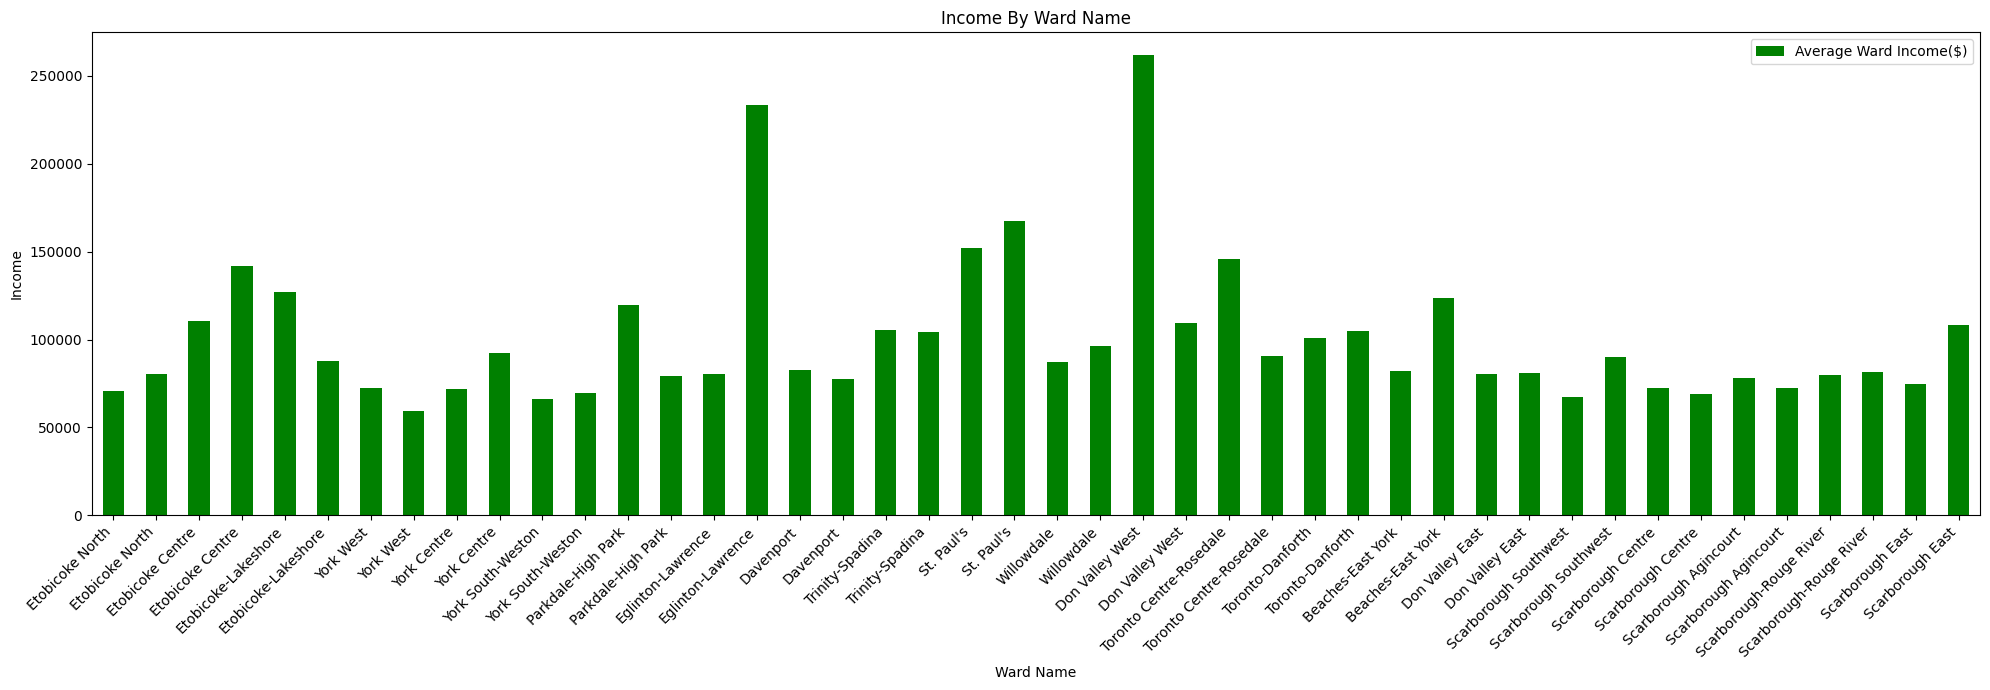

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Bar plot for Average Income by Ward Name
fire_incidents.plot.bar(x='Ward Name', y='Average Ward Income($)', color='green', figsize=(20, 7), title="Income By Ward Name")
plt.xlabel("Ward Name")
plt.ylabel('Income')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig("Income_By_Ward_Name.pdf")
plt.show()

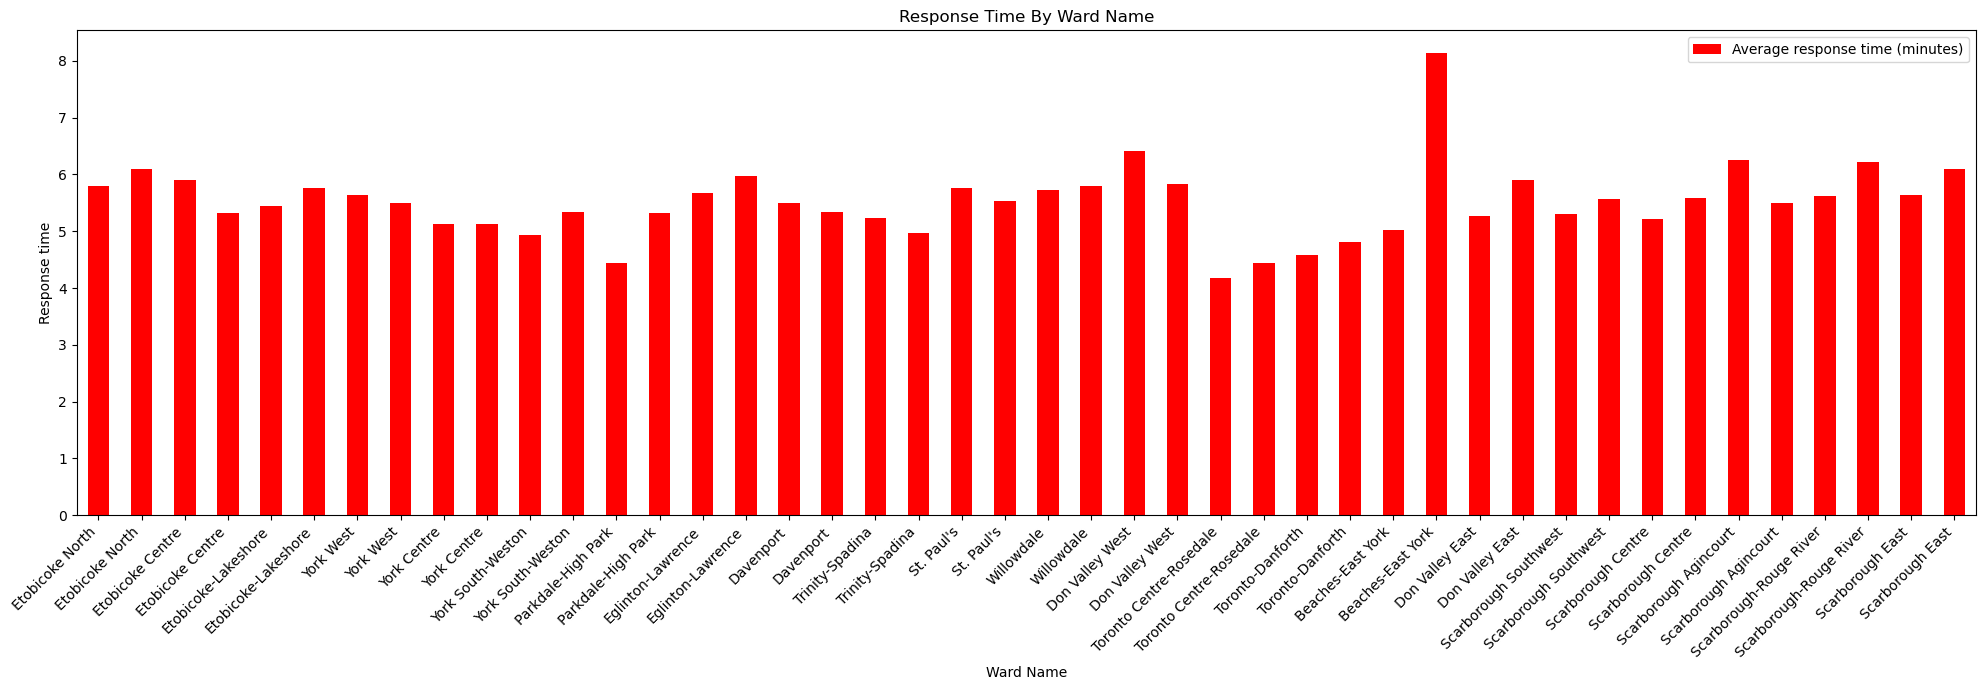

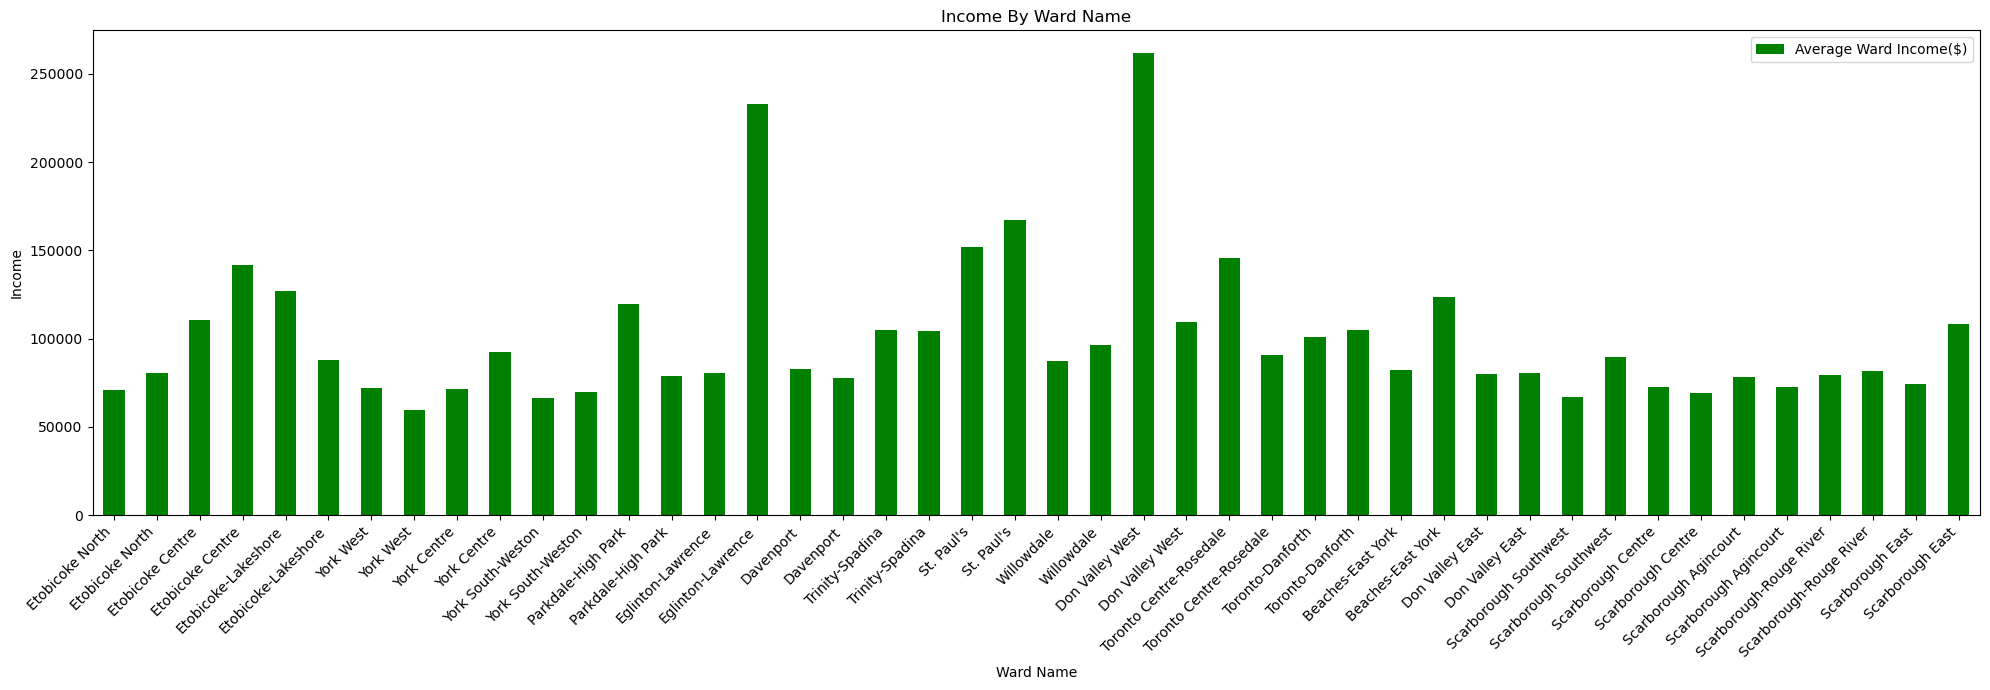

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Bar plot for Average Income by Ward Name
fire_incidents.plot.bar(x='Ward Name', y='Average response time (minutes)', color='red', figsize=(20, 7), title="Response Time By Ward Name")
plt.xlabel("Ward Name")
plt.ylabel('Response time')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig("Response Time By Ward No.pdf")
plt.show()

# Bar plot for Average Income by Ward Name
fire_incidents.plot.bar(x='Ward Name', y='Average Ward Income($)', color='green', figsize=(20, 7), title="Income By Ward Name")
plt.xlabel("Ward Name")
plt.ylabel('Income')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig("Income_By_Ward_Name.pdf")
plt.show()

In [40]:
# Correlation between average response time and average ward income - value 0.18 indicates no correlation between two variables
fire_incidents_income.corr(fire_incidents_response)

0.1820936499795982

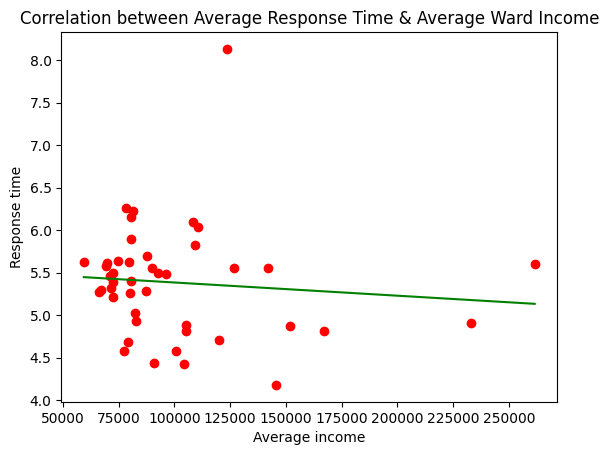

In [32]:
# Scatter Plot with linear regression line showing correlation between two variable - Average Income on Y-axis and Average Response time on X-axis 
import pandas as p  
import numpy as n  
import matplotlib. pyplot as pt  
var1 = fire_incidents_income
var2 = fire_incidents_response
plt. scatter (var1, var2,color='red')  #color='red'
plt. plot (n. unique (var1), n. poly1d (n. polyfit (var1, var2, 1))(n. unique (var1)), color = 'green')
plt.show
pt.title('Correlation between Average Response Time & Average Ward Income')
pt. xlabel ('Average income')  
pt. ylabel ('Response time')
plt.savefig("Income & Response Time By Ward - Line Scatter Plot.pdf")

In [43]:
correlation=fire_incidents_income.corr(fire_incidents_response)

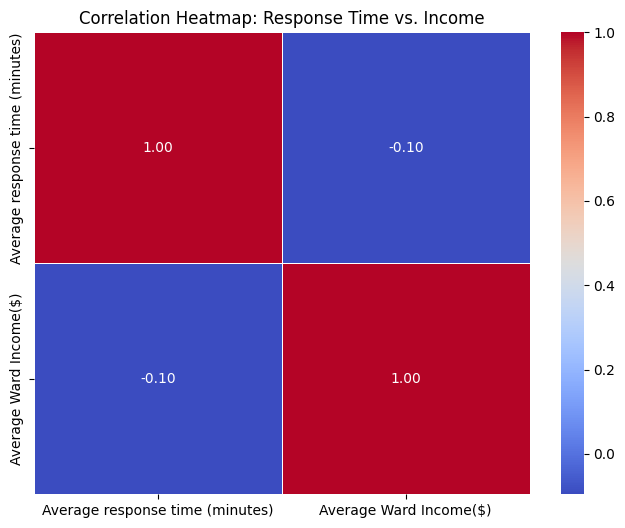

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns
correlation_data = fire_incidents[['Average response time (minutes)', 'Average Ward Income($)']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap: Response Time vs. Income")
plt.savefig("Correlation_Heatmap_Response_Time_Income.pdf")
plt.show()
